# An introduction to Gaussian Processes

In [3]:
%matplotlib inline

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

## Introduction

In this notebook, we'll go over the very basics of Gaussian Processes (GPs) and how to construct and use them. But first, let's review some stuff about the Gausssian distribution $-$ the familiar bell curve $-$ itself.

We're probably all familiar with ``numpy``'s built-in ``np.random.randn()`` function, which draws a sample from the standard normal $\mathcal{N}(0, 1)$, i.e., a Gaussian with zero mean and unit variance:

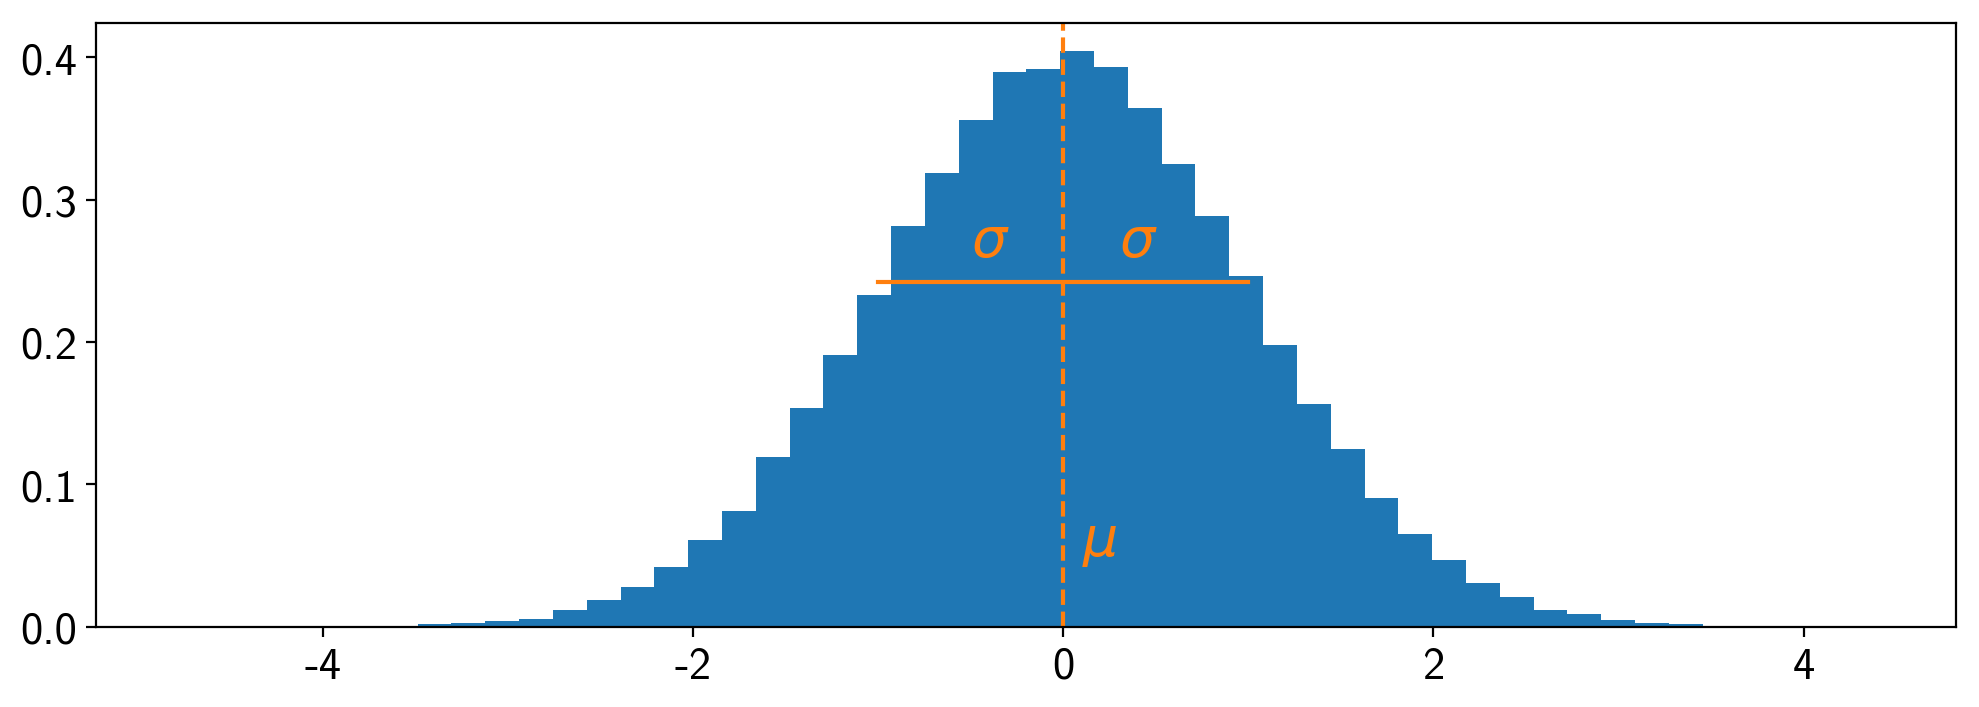

In [8]:
import numpy as np
import matplotlib.pyplot as plt
u = np.random.randn(100000)
plt.hist(u, bins=50, density=1);
plt.axvline(0, color="C1", ls="--")
y = np.exp(-0.5) / (np.sqrt(2 * np.pi))
plt.plot([-1, 1], [y, y], "C1-")
plt.text(0.1, 0.05, r"$\mu$", color="C1", fontsize=20);
plt.text(0.3, 0.26, r"$\sigma$", color="C1", fontsize=20);
plt.text(-0.5, 0.26, r"$\sigma$", color="C1", fontsize=20);

To draw from a Gaussian distribution with a different mean $\mu$, we simply *add* $\mu$ to $u$, and to draw from a distribution with different variance $\sigma^2$, we simply *multiply* $u$ by $\sigma$. We can therefore draw from a Gaussian with mean (say) $10.0$ and variance $5.0^2$ by running

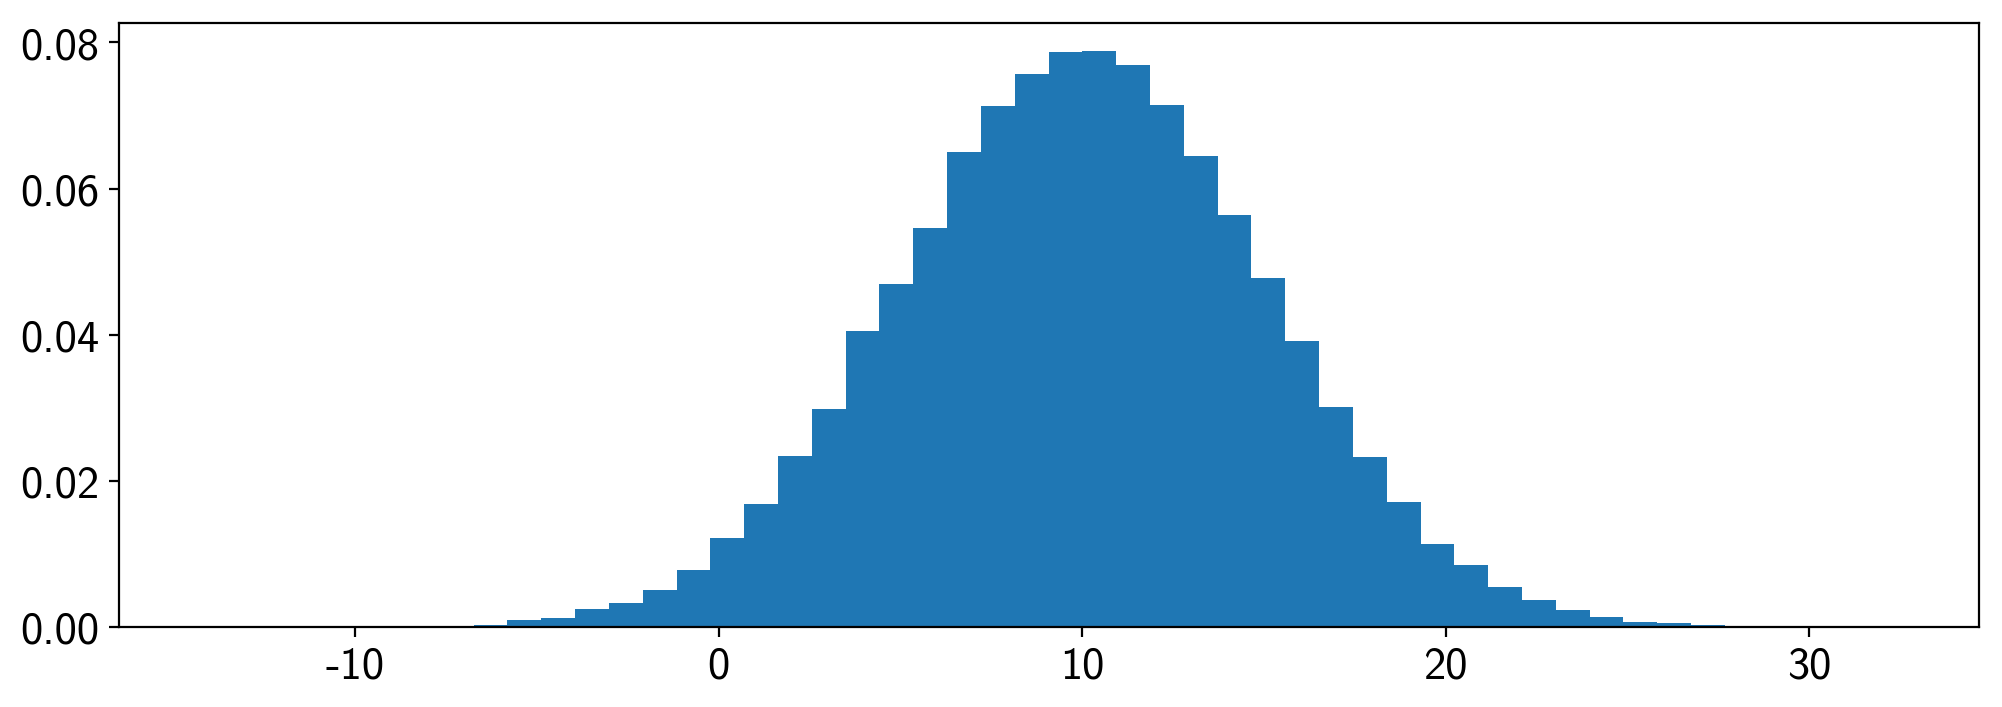

In [44]:
u = np.random.randn(100000)
plt.hist(10.0 + 5.0 * u, bins=50, density=1);

**Easy.** But what about Gaussians in multiple dimensions, where there can be correlations (covariances) between the various dimensions? Say we want to draw from the normal distribution $\mathcal{N}(0, \mathbf{\Sigma})$, where $\mathbf{\Sigma}$ is the *covariance matrix*:

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 \mathrm{Var(x_0)} & \mathrm{Cov(x_0, x_1)} & \cdots & \mathrm{Cov(x_0, x_N)} \\ \\
 \mathrm{Cov(x_1, x_0)} & \mathrm{Var(x_1)} & \cdots & \mathrm{Cov(x_1, x_N)} \\ \\
 \vdots & \vdots & \ddots & \vdots \\ \\
 \mathrm{Cov(x_N, x_0)} & \mathrm{Cov(x_N, x_1)} & \cdots & \mathrm{Var(x_N)}
\end{pmatrix}
$$

Here, $\mathrm{Var(x_i)}$ is the variance, or square of the standard deviation, along the $i^\mathrm{th}$ dimension, and $\mathrm{Cov(x_i, x_j)}$ is the covariance $-$ a measure of how two variables vary jointly $-$ between the $i^\mathrm{th}$ and $j^\mathrm{th}$ dimensions.

It's hard to picture a multivariate Gaussian, but it helps to imagine what the contours of equal probability (or equipotential surfaces) look like. For a two dimensional standard normal with no covariance ($\mathbf{\Sigma} = \mathbf{I}$), these are just circles. As I add to the off-diagonal terms of the matrix, I introduce a preferred direction in the space, since now the dimensions are correlated. The circle becomes an ellipse whose elongation increases with the covariance. In the general case of a multidimensional Gaussian, the contours form a multidimensional ellipsoid, elongated by different amounts along different dimensions.

**So.** How do we draw samples from a multivariate Gaussian given $\mathbf{\Sigma}$? It turns out there's a simple trick. Take $u$ to be a variable drawn from the standard normal (as we did above with ``u = np.random.randn()``) in $N$ dimensions. If we transform $u$ by a yet-to-be-determined operator (matrix) $\mathbf{L}$,

$$
\begin{align}
x = \mathbf{L}u
\end{align}
$$

we now have a random variable $x$ whose variance is

$$
\begin{align}
\mathrm{Var}(x) &\equiv \left< x x^\top \right> \\
                &= \left< \left(\mathbf{L}u\right) \left(\mathbf{L}u \right)^\top \right> \\
                &= \left< \mathbf{L} uu^\top \mathbf{L}^\top \right> \\
                &= \mathbf{L} \left<uu^\top\right> \mathbf{L}^\top \\
                &= \mathbf{L} \mathrm{Var}(u) \mathbf{L}^\top \\
                &= \mathbf{L}\mathbf{L}^\top.
\end{align}
$$

In the expressions above, I used the fact that the variance of a random variable is defined as the expectation value (denoted by $\left<\,\right>$) of the squared deviation from the mean (zero, in this case). The expectation value of $\mathbf{L}$ is just $\mathbf{L}$ (since it is constant), and the variance of $u$ is unity (by construction).

Now, all we have to do is find a matrix $\mathbf{L}$ such that

$$
\begin{align}
\mathbf{\Sigma} &= \mathbf{L} \mathbf{L}^\top
\end{align}
$$

and we're done!

**But how do we do that?** As it happens, what we're trying to do has a name: it's the **Cholesky decomposition** of $\mathbf{\Sigma}$. Formally, all the Cholesky decomposition does is to find a factorization of a matrix $\mathbf{\Sigma}$ in the form given by the expression above, where $\mathbf{L}$ is a lower triangular matrix. You can (informally) think of this decomposition as finding the square root of $\mathbf{\Sigma}$, and it is *enormously* useful for GPs (and linear algebra in general). Note that the Cholesky decomposition only works for Hermitian (symmetric), positive-definite matrices, but those are the only kinds of matrices we'll be dealing with here anyways.

To perform the Cholesky decomposition in Python, use ``scipy``:

```python
from scipy.linalg import cho_factor
L, _ = cho_factor(S, lower=True)  # Compute the lower triangular matrix L
L = np.tril(L)                    # Ensure the upper triangle of L is zeroed out
```

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1a</h1>
</div>

Define a function ``draw_from_gaussian(mu, S, ndraws=1)`` that returns ``ndraws`` samples from a multivariate Gaussian with mean ``mu`` and covariance matrix ``S``. The shape of the output should be ``(ndraws, ndim)`` where ``ndim`` is the dimension of the Gaussian. Note that as ``S`` gets large, roundoff error can often accumulate in the Cholesky decomposition, potentially causing weird ``LinearAlgebraError``s. For this reason, it's good practice to always add a tiny number to the diagonal of a matrix (something like ``1e-12``) whenever decomposing it, factorizing it, inverting it, etc. You probably want to bake that into your code to compute ``L``.

In [67]:
def draw_from_gaussian(mu, K, ndraws=1, eps=1e-12):
    """
    Generate samples from a multivariate gaussian
    specified by covariance ``K`` and mean ``mu``.
    
    """
    npts = K.shape[0]
    L, _ = cho_factor(K + eps * np.eye(npts), lower=True)
    L = np.tril(L)
    u = np.random.randn(npts, ndraws)
    x = np.dot(L, u) + mu[:, None]
    return x.T

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1b</h1>
</div>

Draw ``10,000`` samples from a zero-mean Gaussian with covariance

$$
\mathbf{\Sigma} =
\begin{pmatrix}
 1 & 0.5 \\
 0.5 & 1
\end{pmatrix}
$$

Plot the "corner" plot for your ``samples`` using the ``corner`` package (``!pip install corner``):

```python
from corner import corner
fig = corner(samples);
```

Vary the terms in the covariance matrix (recalling that it must be symmetric!) to get a sense of how they affect the joint distribution of samples.

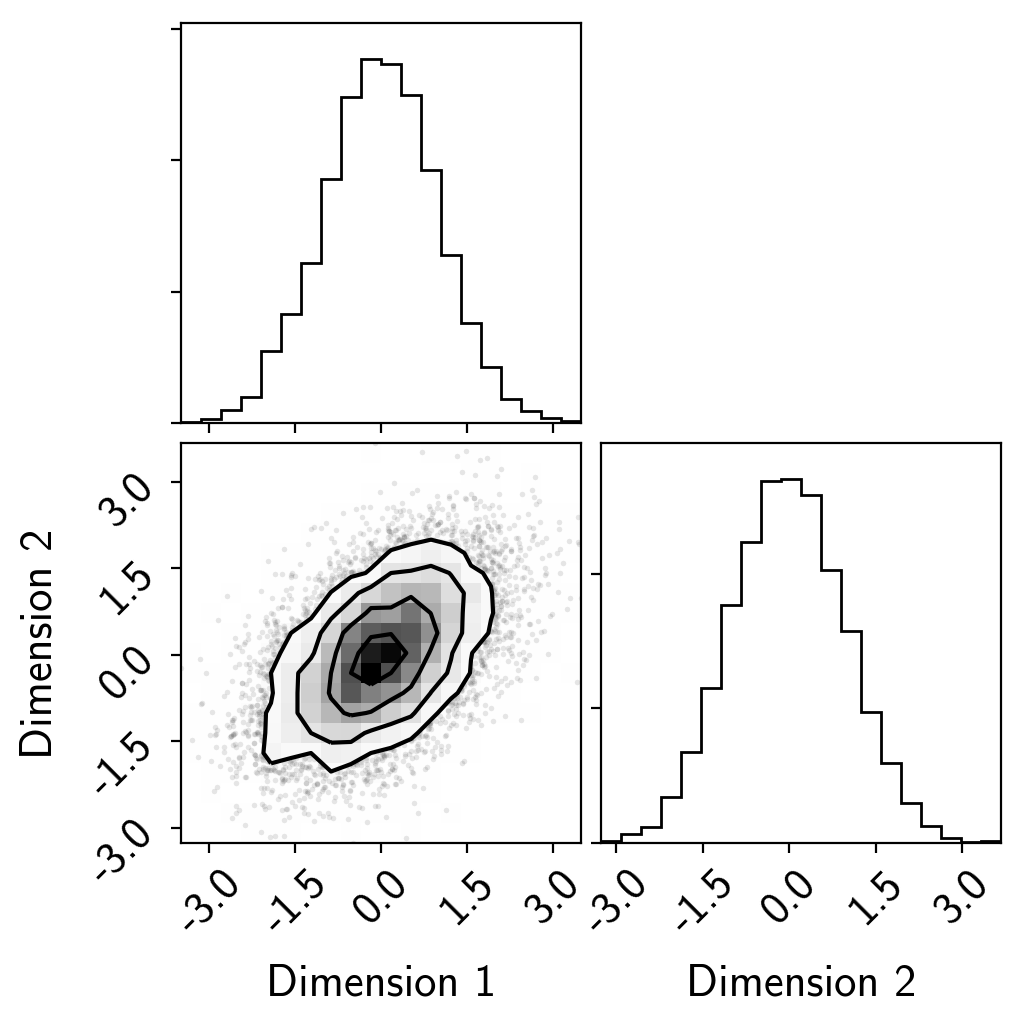

In [117]:
from corner import corner
mu = np.zeros(2)
K = np.array([[1.0, 0.5], [0.5, 1.0]])
samples = draw_from_gaussian(mu, K, ndraws=10000)
labels = ["Dimension 1", "Dimension 2"]
fig = corner(samples, labels=labels);

## Parametrizing the covariance

As the number of dimensions increases, and in particular as it becomes *infinite* (which it will, when we get to actual Gaussian Processes), it's no longer convenient to describe the covariance in terms of every single entry in the covariance matrix. Instead, it's useful to introduce the notion of a *kernel*, a function of just a few parameters that describes the overall structure of the covariance matrix.

In general, the covariance matrix can have *any* structure, but quite often in timeseries analysis *data points close to each other in time are strongly correlated*. This is true whether your timeseries contains photometric variability from a rotating star, the rise and fall of a supernova light curve, a gravitational wave signal, or PSF shape changes due to temperature fluctuations on the detector. This is because each of these processes have characteristic timescales over which they operate, and on timescales shorter than that, all measurements you make are likely to be close to relatively each other. But if you wait long enough, what your system will do down the line will be pretty decoupled from what it is doing right now.

So we can imagine defining a kernel that looks something like this:

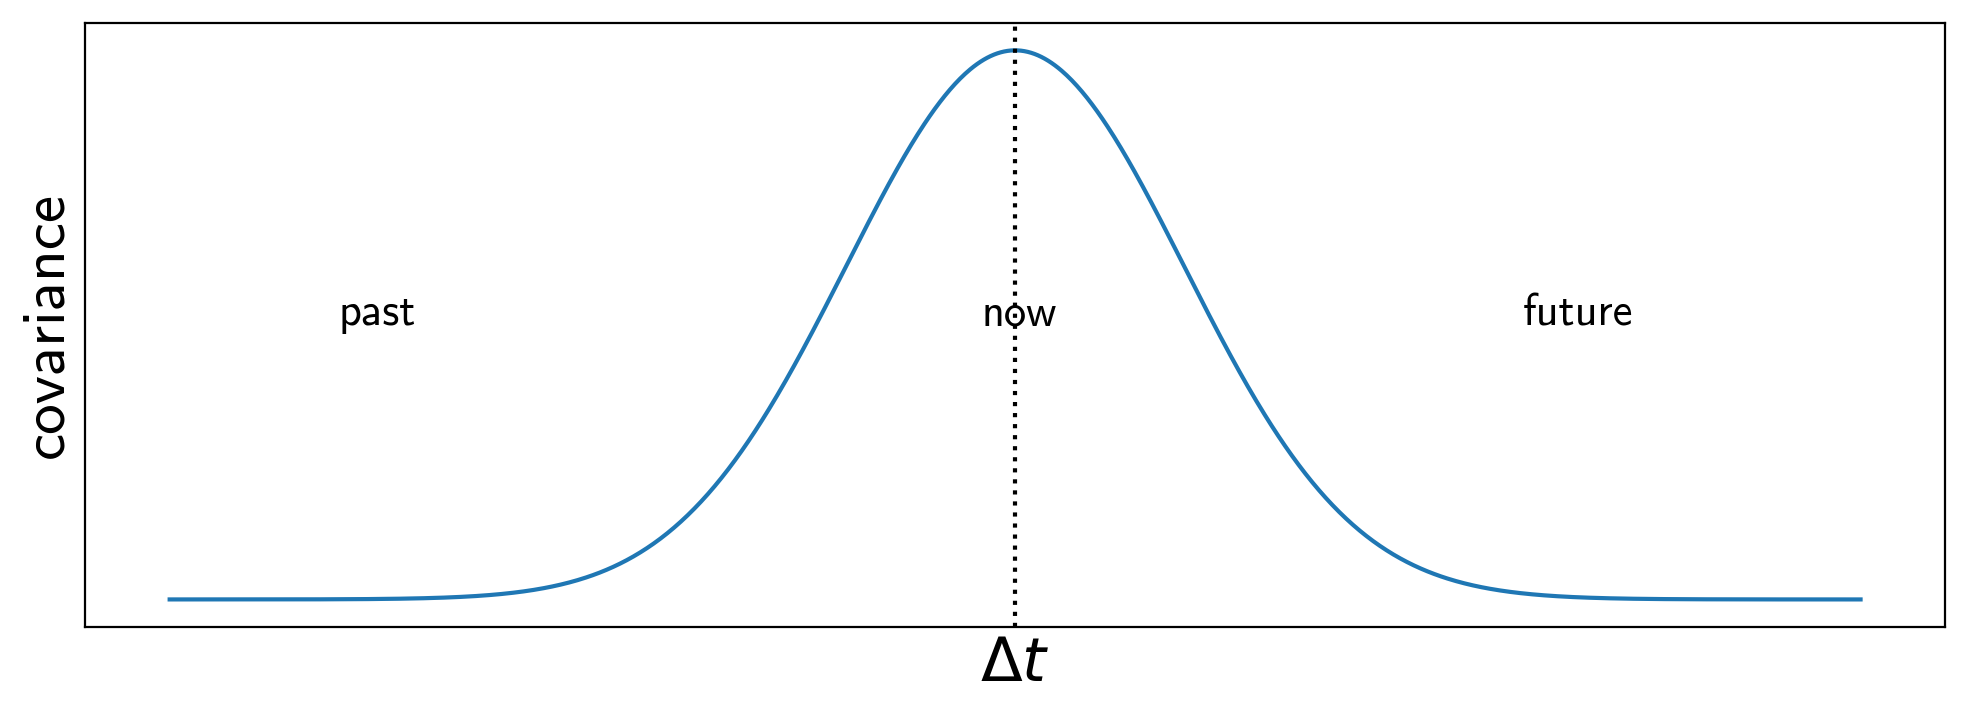

where the covariance peaks at zero time lag and drops smoothly to zero as the time lag increases. This particular kernel is extremely useful and has a name: the *Squared Exponential Kernel*, defined as

$$
\begin{align}
    k(t_i, t_j)
\end{align}
$$

**TODO!!!**

In [ ]:
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.exp(-0.5 * x ** 2));
plt.xlabel(r"$\Delta t$", fontsize=22)
plt.ylabel("covariance", fontsize=22)
plt.axvline(0, color="k", ls=":")
plt.text(-4, 0.5, "past")
plt.text(-0.2, 0.5, "now")
plt.text(3, 0.5, "future")
plt.xticks([])
plt.yticks([]);

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2</h1>
</div>

In [7]:
def ExpSquaredKernel(x1, x2=None, a=1.0, l=1.0):
    """
    Return the ``N x M`` exponential squared
    covariance matrix.
    
    """
    if x2 is None:
        x2 = x1
    X2, X1 = np.meshgrid(x2, x1)
    return a ** 2 * np.exp(-0.5 * (X1 - X2) ** 2 / l ** 2)

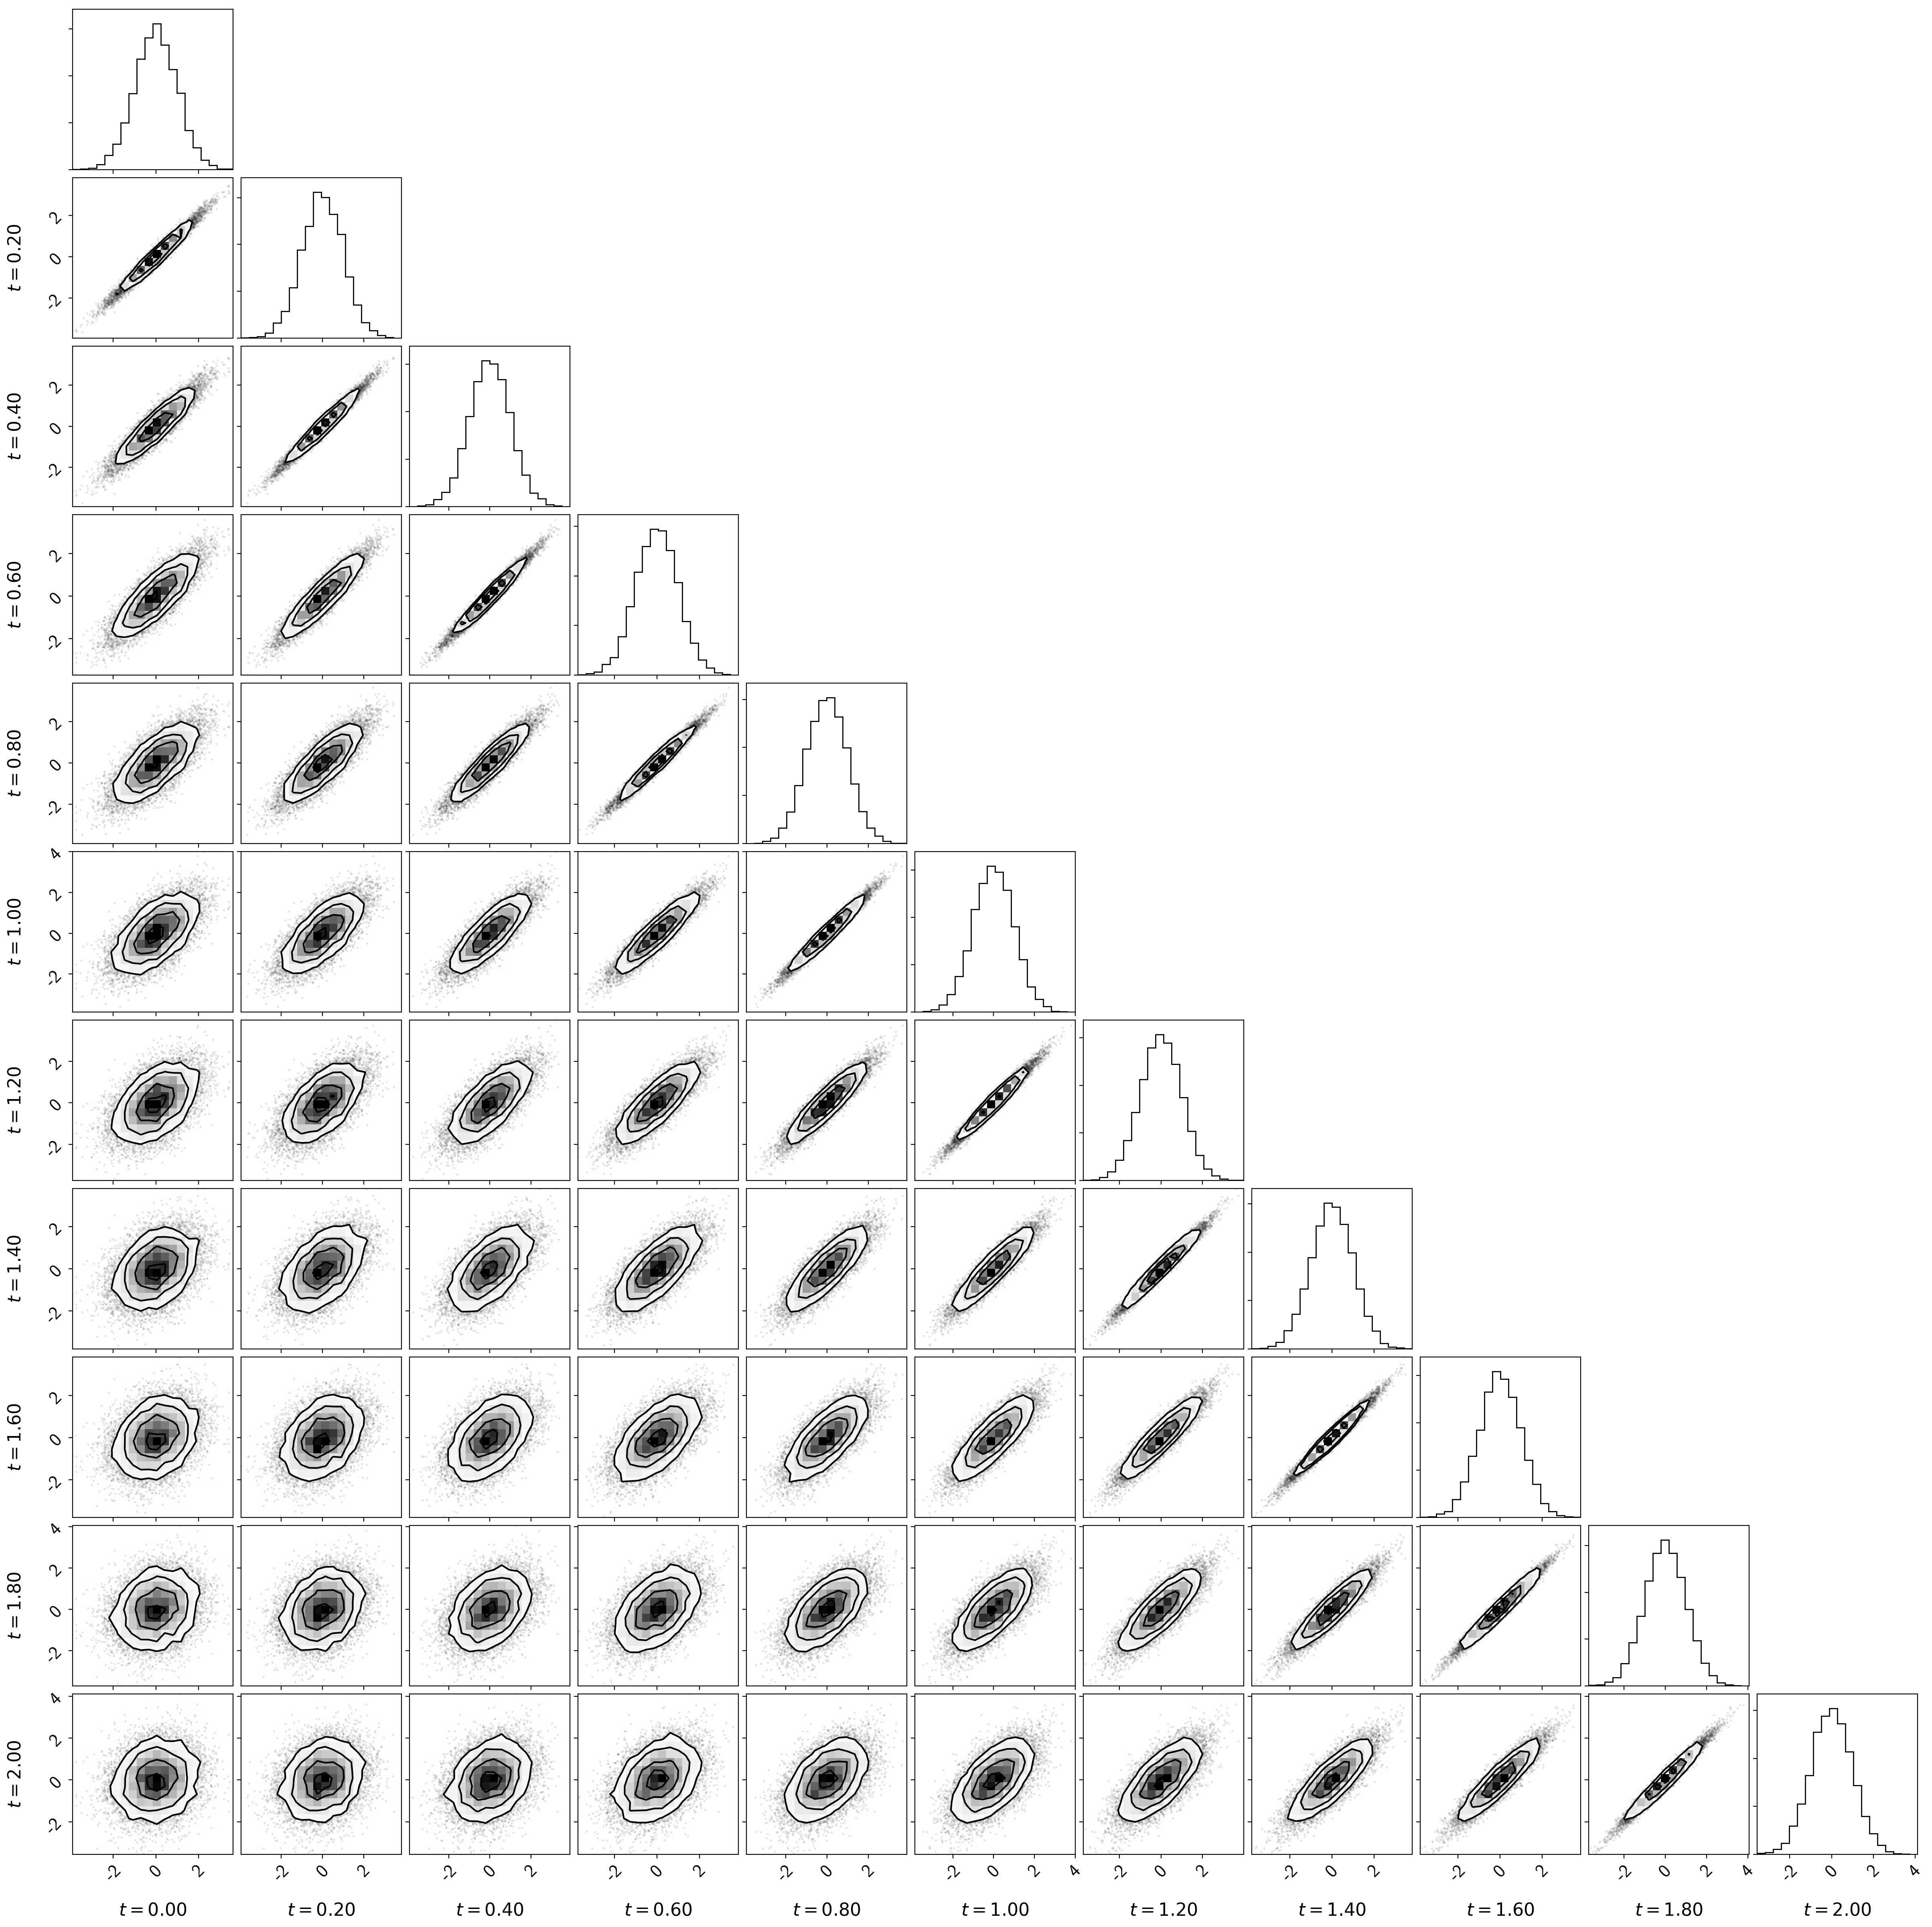

In [56]:
t = np.linspace(0, 2, 11)
mu = np.zeros_like(t)
K = ExpSquaredKernel(t)
samples = draw_from_gaussian(mu, K, ndraws=10000, eps=0).T
labels = [r"$t=%.2f$" % ti for ti in t]
fig = corner(samples, labels=labels);

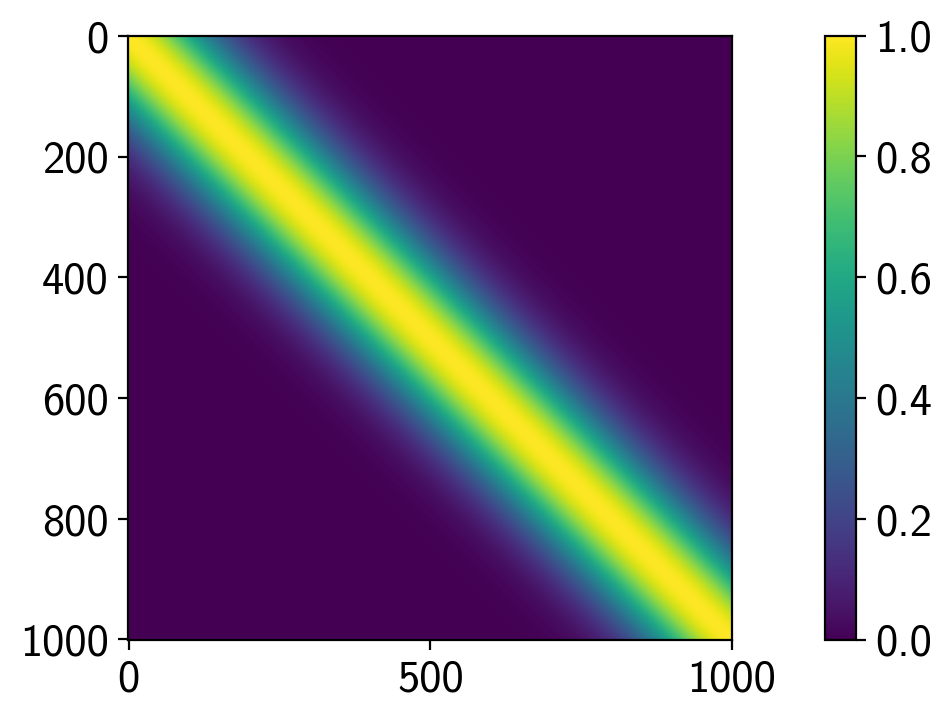

In [59]:
t = np.linspace(0, 10, 1001)
K = ExpSquaredKernel(t)
plt.imshow(K)
plt.colorbar();

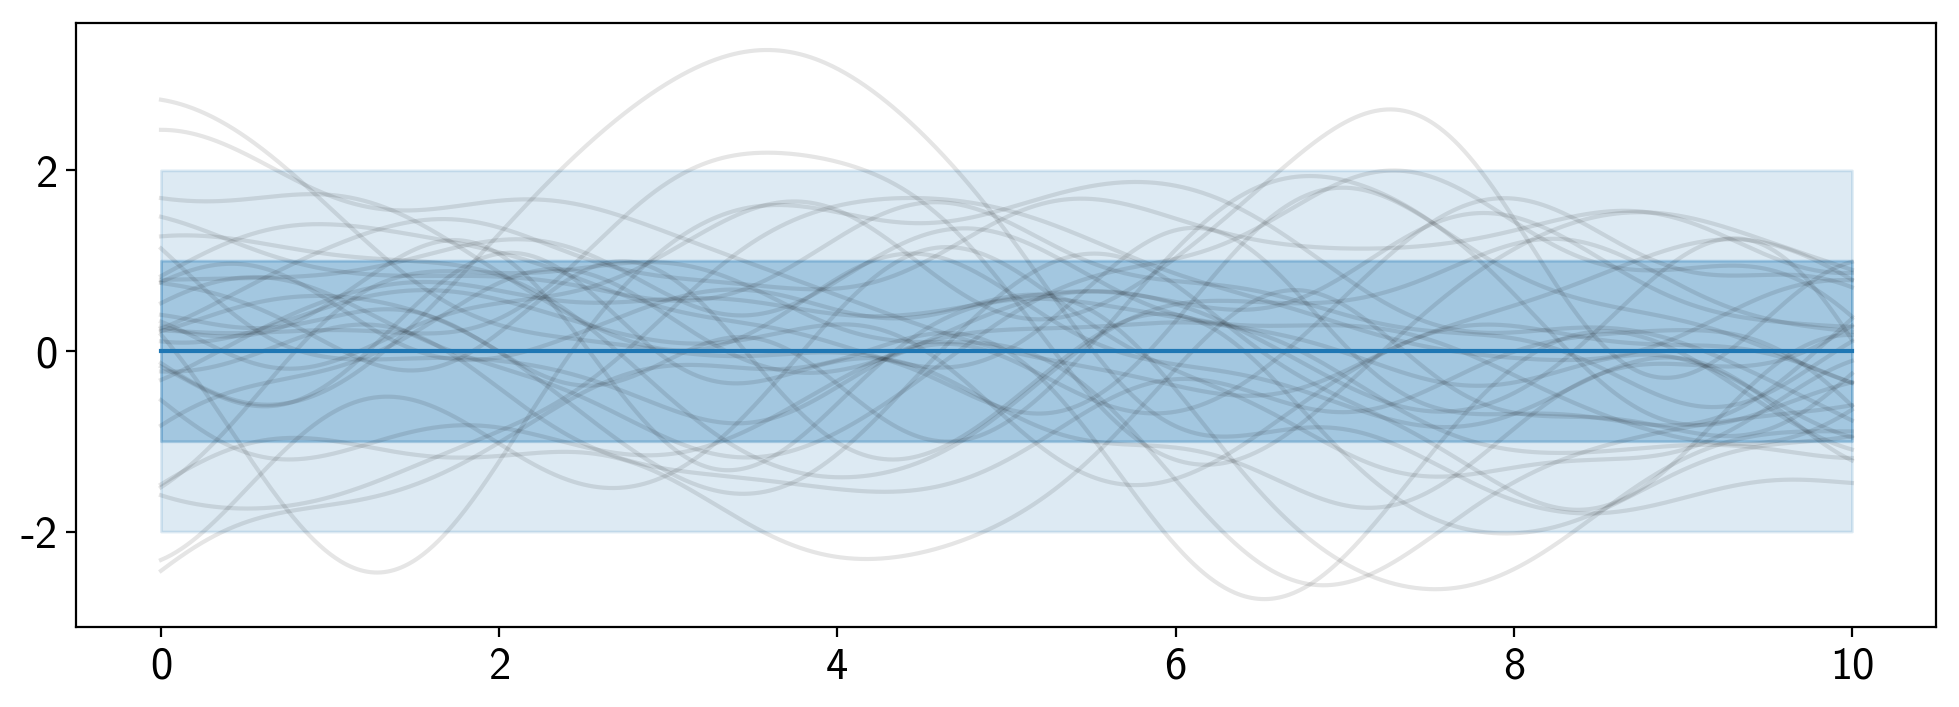

In [62]:
mu = np.zeros_like(t)
for i in range(30):
    samples = draw_from_gaussian(mu, K)
    plt.plot(t, samples, color="k", alpha=0.1)

mu_ = np.zeros_like(t)
plt.plot(t, mu_, color="C0")
std_ = np.sqrt(K.diagonal())
plt.fill_between(t, mu_ - std_, mu_ + std_, color="C0", alpha=0.3);
plt.fill_between(t, mu_ - 2 * std_, mu_ + 2 * std_, color="C0", alpha=0.15);

That's **it**!

In [12]:
def compute_gp(ttest, ftest, tpred, sigma=0, kernel=ExpSquaredKernel, **kwargs):
    """
    
    """
    # Compute the required matrices
    Ktt = kernel(ttest, **kwargs)
    Ktt += sigma ** 2 * np.eye(Ktt.shape[0])
    Kpp = kernel(tpred, **kwargs)
    Kpt = kernel(tpred, ttest, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Kpt, np.linalg.solve(Ktt, ftest))
    K = Kpp - np.dot(Kpt, np.linalg.solve(Ktt, Kpt.T))
    
    return mu, K    

In [13]:
ttest = np.array([2.5, 7.5])
ftest = np.array([1.0, -1.0])
tpred = np.linspace(0, 10, 1001)

gp_mu, gp_K = compute_gp(ttest, ftest, tpred)

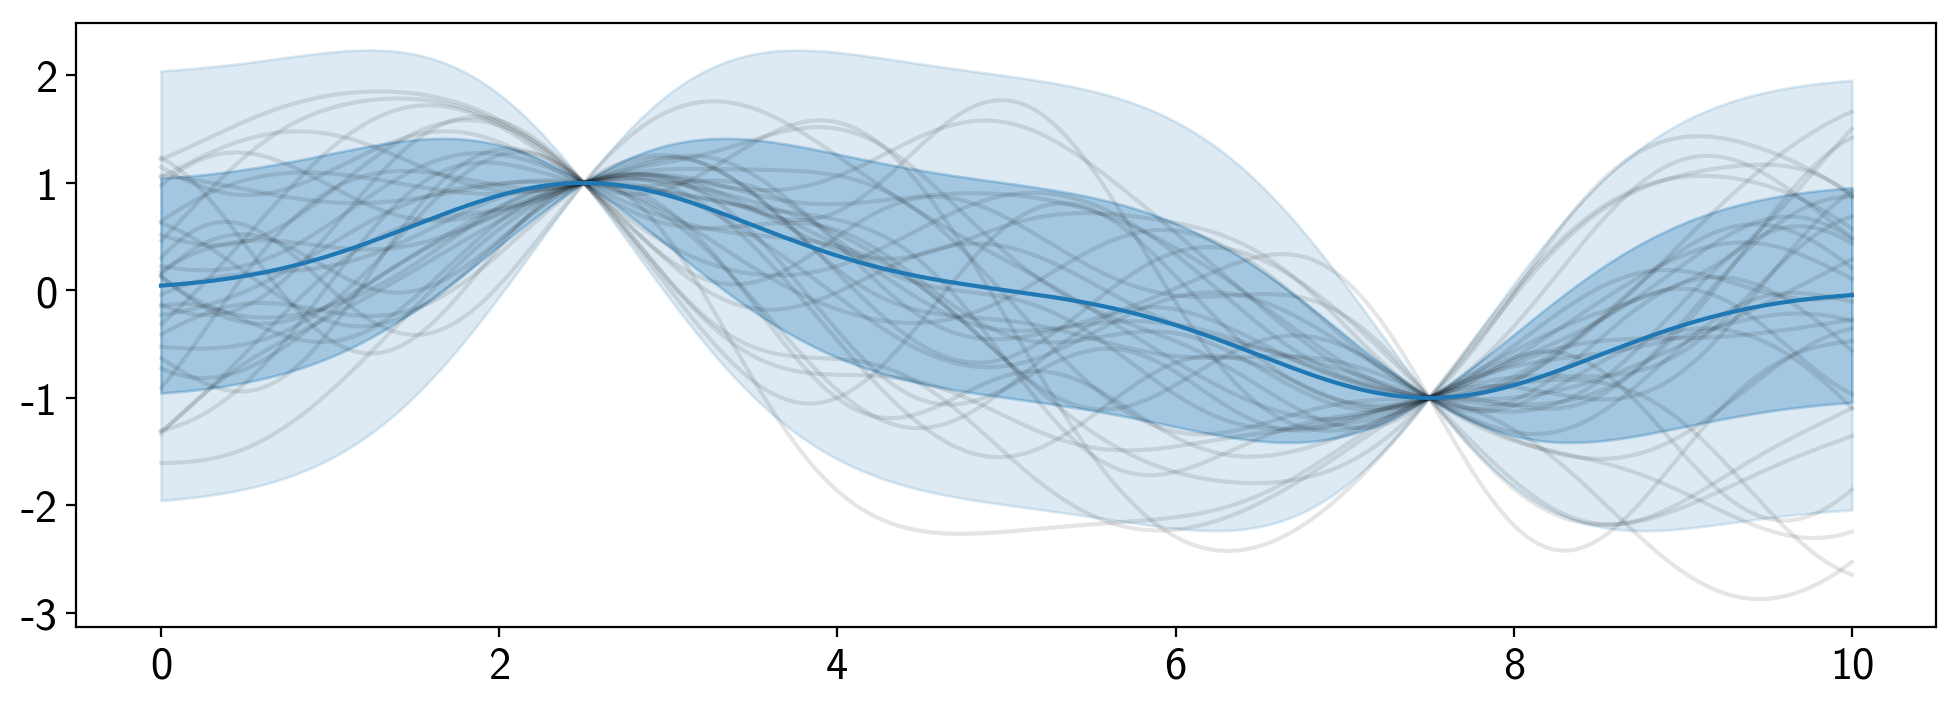

In [14]:
for i in range(30):
    samples = draw_from_gaussian(gp_mu, gp_K)
    plt.plot(t, samples, color="k", alpha=0.1)

plt.plot(t, gp_mu, color="C0")
std_ = np.sqrt(gp_K.diagonal())
plt.fill_between(t, gp_mu - std_, gp_mu + std_, color="C0", alpha=0.3);
plt.fill_between(t, gp_mu - 2 * std_, gp_mu + 2 * std_, color="C0", alpha=0.15);

In [15]:
def marginal_likelihood(t, y, sigma=0, kernel=ExpSinSquaredKernel, **kwargs):
    """
    
    """
    # The covariance and its determinant
    npts = len(t)
    K = kernel(t, **kwargs) + sigma ** 2 * np.eye(npts)
    detK = np.linalg.det(K)
    
    # The marginal likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= -0.5 * np.log(detK)
    log_like -= 0.5 * npts * np.log(2 * np.pi)
    
    return log_like

In [16]:
# TODO: Dfm's fitting a line example.